# Modeling For E-Commerence Customer Churn Prediction

In this notebook:
- Split the Data
- Handle Class Imbalance
- Establish A Pipeline
- Train Multiple Classification Models
- Evaluate using Precision, Recall, AUC-ROC
- Select the best performing model

In [1]:
import pandas as pd
cleaned_ecom_df = pd.read_csv('../data/Cleaned_Ecom.csv')

In [2]:
# Split the Data
from sklearn.model_selection import train_test_split

cleaned_ecom_df = cleaned_ecom_df.drop(['AvgOrdersPerMaritalStatus','AvgOrdersPerPaymentMode'],axis=1)

X = cleaned_ecom_df.drop(['Churn', 'CustomerID'],axis=1)
y = cleaned_ecom_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42,stratify=y)

Metrics for Logistic Regression
Accuracy: 0.8845470692717584
Recall: 0.6263157894736842
PR-AUC: 0.48177179782633583
AUC-ROC: 0.872795771479982
Brier: 0.09400025276049487
Metrics for Random Forest Classifier
Accuracy: 0.9804618117229129
Recall: 0.9157894736842105
PR-AUC: 0.899472749368982
AUC-ROC: 0.9986813990103464
Brier: 0.028834991119005324
Metrics for XGB Classifier
Accuracy: 0.9849023090586145
Recall: 0.9526315789473684
PR-AUC: 0.9203014443549172
AUC-ROC: 0.9984986504723348
Brier: 0.011872329604855856


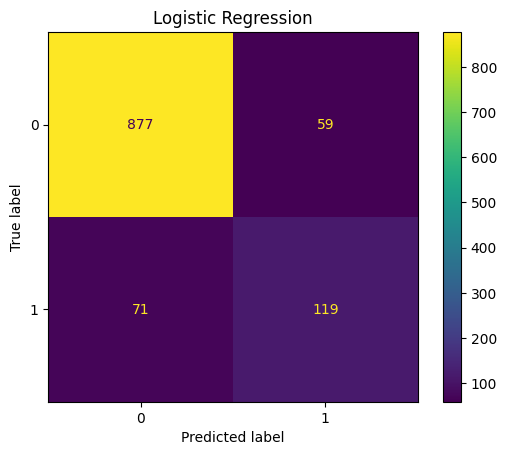

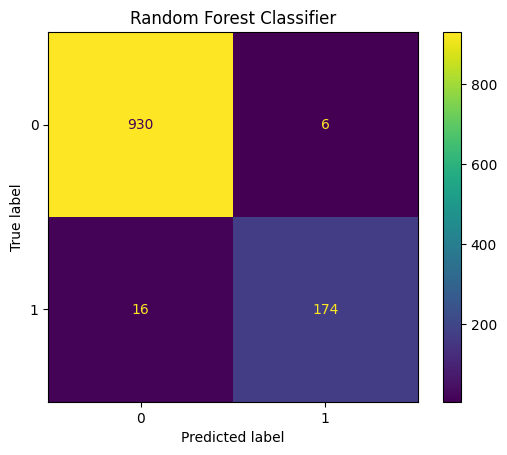

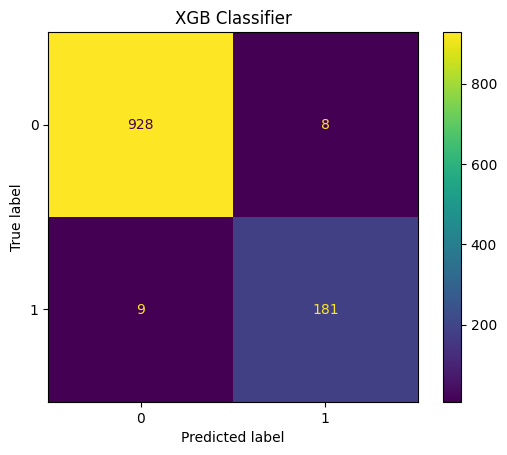

In [3]:
# Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, roc_auc_score, recall_score,
                             average_precision_score, brier_score_loss, 
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import joblib

pipeline_lr = Pipeline([
    ('smote',SMOTE()),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression())
])

pipeline_rfc = Pipeline([
    ('smote',SMOTE()),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier())
])

pipeline_xgb = Pipeline([
    ('smote',SMOTE()),
    ('scaler', MinMaxScaler()),
    ('model', XGBClassifier())
])

pipelines = {
    'Logistic Regression': pipeline_lr,
    'Random Forest Classifier': pipeline_rfc,
    'XGB Classifier': pipeline_xgb,
}

for name, model in pipelines.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f'Metrics for {name}')
    print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
    print(f'Recall: {recall_score(y_test,y_pred)}')
    print(f'PR-AUC: {average_precision_score(y_test,y_pred)}')
    print(f'AUC-ROC: {roc_auc_score(y_test,y_proba)}')
    print(f'Brier: {brier_score_loss(y_test,y_proba)}')

    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)
    plt.title(f'{name}')

    print('='*50)

    joblib.dump(model,f'../models/{name.replace(" ", "_")}.pkl')


### Model Interpretations
- Both Models perform well with XGB slightly outperforming RFC. This means that XGB is slightly better at predicting churn vs. non-churn. Precision is the first priority in order to minimize false positives.

In [4]:
# Feature Importances

rfc = joblib.load('../models/Random_Forest_Classifier.pkl')
xgb = joblib.load('../models/XGB_Classifier.pkl')

rfc.named_steps['model'].feature_importances_
xgb.named_steps['model'].feature_importances_

for model in [rfc,xgb]:
    importances = model.named_steps['model'].feature_importances_

    feature_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance',ascending=False)

    print(feature_df.head(10))
    print("\n")




                        Feature  Importance
0                        Tenure    0.225514
12               CashbackAmount    0.066638
35         MaritalStatus_Single    0.059558
11            DaySinceLastOrder    0.056762
13             CashbackPerOrder    0.054248
2               WarehouseToHome    0.048293
8   OrderAmountHikeFromlastYear    0.040100
6               NumberOfAddress    0.034024
9                    CouponUsed    0.031471
25                Gender_Female    0.026295


                              Feature  Importance
34              MaritalStatus_Married    0.124634
33             MaritalStatus_Divorced    0.120357
0                              Tenure    0.102085
35               MaritalStatus_Single    0.059715
25                      Gender_Female    0.048011
27           PreferedOrderCat_Fashion    0.045207
17         PreferredLoginDevice_Phone    0.039176
23      PreferredPaymentMode_E wallet    0.034115
9                          CouponUsed    0.027905
16  PreferredL